In [85]:
import outlaw.nb_util as nb_util
nb_util.setup_nb()

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

In [2]:
# grid in sig1/sig2
# grid in (mu1 - mu2) / sqrt(sig1^2 + sig2^2)
# welch's t-test

In [3]:
n = 20
def simulate(nsims, mu2, sig2):
    arm1 = np.random.normal(0, 1, size=(nsims, n))
    arm2 = np.random.normal(mu2, np.sqrt(sig2), size=(nsims, n))
    return arm1, arm2

def compute_rejections(arm1, arm2):
    res = scipy.stats.ttest_ind(arm1, arm2, equal_var=False, axis=1)
    reject = res[1] < 0.05
    n_rejections = np.sum(reject)
    return n_rejections

In [4]:
def simulate_jax(key, nsims, mu2, sig2):
    key1, key2 = jax.random.split(key, 2)
    arm1 = jax.random.normal(key1, shape=(nsims, n))
    arm2 = jax.random.normal(key2, shape=(nsims, n)) * jnp.sqrt(sig2) + mu2
    return arm1, arm2


def cr2(arm1, arm2):
    n1 = arm1.shape[0]
    n2 = arm2.shape[0]
    mu1 = jnp.mean(arm1)
    mu2 = jnp.mean(arm2)
    v1 = jnp.var(arm1, ddof=1)
    v2 = jnp.var(arm2, ddof=1)
    vn1 = v1 / n1
    vn2 = v2 / n2

    df = (vn1 + vn2) ** 2 / (vn1**2 / (n1 - 1) + vn2**2 / (n2 - 1))
    df = jnp.where(jnp.isnan(df), 1, df)
    denom = jnp.sqrt(vn1 + vn2)

    # two-tailed test
    t = (mu1 - mu2) / denom
    # p = scipy.special.stdtr(df, -np.abs(t)) * 2
    x = df / (t**2 + df)
    p = jax.scipy.special.betainc(df / 2, 0.5, x)
    return t, p


arm1, arm2 = simulate(1, 0.1, 0.9)
scipy_res = scipy.stats.ttest_ind(arm1, arm2, equal_var=False, axis=1)
my_t, my_p = jax.jit(cr2)(arm1[0], arm2[0])
np.testing.assert_allclose(my_t, scipy_res[0], atol=1e-5)
np.testing.assert_allclose(my_p, scipy_res[1], atol=1e-5)


In [5]:
def sim_and_compute(key, nsims, mu2, sig2):
    arms = simulate_jax(key, nsims, mu2, sig2)
    _, p = jax.vmap(cr2)(*arms)
    reject = p < 0.05
    n_rejections = jnp.sum(reject)
    return n_rejections

nsims = 10000
mus = np.linspace(-1, 2, 31)
sigs = np.linspace(0.1, 3, 30)
jax_reject_f = jax.jit(jax.vmap(jax.vmap(sim_and_compute, in_axes=(0, None, None, 0)), in_axes=(0, None, 0, None)), static_argnums=(1,))
keys = jax.random.split(jax.random.PRNGKey(0), mus.shape[0] * sigs.shape[0]).reshape((mus.shape[0], sigs.shape[0], 2))
reject_grid = jax_reject_f(keys, nsims, mus, sigs)

In [6]:
%%timeit
jax_reject_f(keys, nsims, mus, sigs)

124 ms ± 376 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


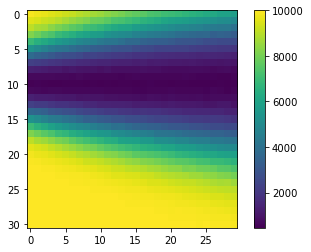

In [8]:
plt.imshow(reject_grid)
plt.colorbar()
plt.show()

In [82]:
n_test = 2000
rand_pts = np.random.uniform(size=(n_test, 2))
rand_pts[:, 1] += 0.1

In [83]:
nsims_test = nsims * 50
test_reject = np.empty(n_test)
keys_test = jax.random.split(jax.random.PRNGKey(1), n_test)
jax_test_f = jax.jit(jax.vmap(sim_and_compute, in_axes=(0, None, 0, 0)), static_argnums=(1,))
test_reject = np.empty(n_test)
baseline_reject = np.empty(n_test)
chunk_size = 10
for i in range(0, n_test, chunk_size):
    end = min(n_test, i + chunk_size)
    test_reject[i:end] = jax_test_f(keys_test[i:end], nsims_test, rand_pts[i:end, 0], rand_pts[i:end, 1])
    baseline_reject[i:end] = jax_test_f(keys_test[i:end], nsims, rand_pts[i:end, 0], rand_pts[i:end, 1])

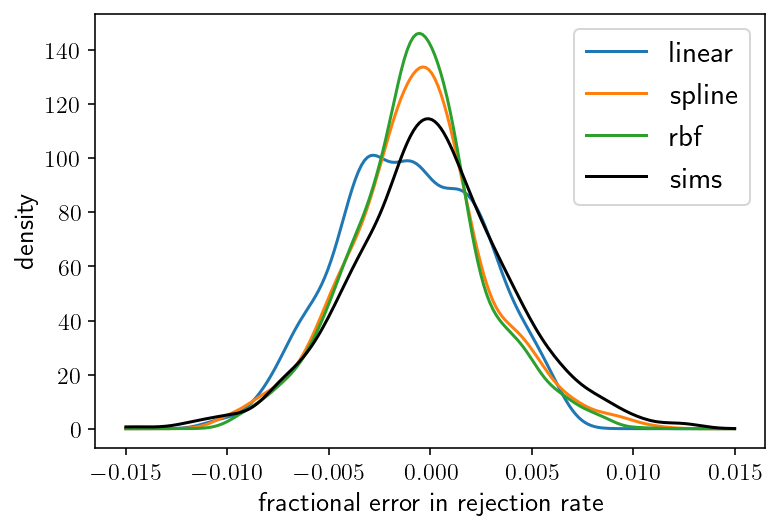

In [87]:

interp_reject_linear = scipy.interpolate.interpn(
    (mus, sigs), reject_grid, rand_pts, method='linear'
)
interp_reject_spline = scipy.interpolate.interpn(
    (mus, sigs), reject_grid, rand_pts, method='splinef2d'
)
mu_grid, sig_grid = np.meshgrid(mus, sigs, indexing='ij')
grid = np.stack((mu_grid.ravel(), sig_grid.ravel()), axis=1)

interp_rbf = scipy.interpolate.RBFInterpolator(
    grid, reject_grid.ravel(), neighbors=30, #, kernel="quintic"
)(rand_pts)

from scipy.stats import gaussian_kde

linear_err = (test_reject / nsims_test) - (interp_reject_linear / nsims)
spline_err = (test_reject / nsims_test) - (interp_reject_spline / nsims)
rbf_err = (test_reject / nsims_test) - (interp_rbf / nsims) 
baseline_err = (test_reject / nsims_test) - (baseline_reject / nsims) 
xs = np.linspace(-0.015, 0.015, 200)
plt.plot(xs, gaussian_kde(linear_err)(xs), label='linear')
plt.plot(xs, gaussian_kde(spline_err)(xs), label='spline')
plt.plot(xs, gaussian_kde(rbf_err)(xs), label='rbf')
plt.plot(xs, gaussian_kde(baseline_err)(xs), 'k-', label='sims')
plt.legend()
plt.ylabel('density')
plt.xlabel('fractional error in rejection rate')
plt.show()

## Junk

In [ ]:
# %%time
# nsims = 10000
# mus = np.linspace(-1, 2, 31)
# sigs = np.linspace(0.1, 3, 30)
# reject_grid = np.empty((mus.shape[0], sigs.shape[0]))
# for i, m in enumerate(mus):
#     for j, s in enumerate(sigs):
#         reject_grid[i, j] = compute_rejections(*simulate(nsims, m, s))

In [79]:
# sample_mean1 = np.mean(arm1, axis=1)
# sample_mean2 = np.mean(arm2, axis=1)
# std_err1 = np.std(arm1, axis=1) / np.sqrt(n)
# std_err2 = np.std(arm2, axis=1) / np.sqrt(n)
# T = (sample_mean1 - sample_mean2) / np.sqrt(std_err1**2 + std_err2**2)

In [ ]:

# kde_reject = scipy.stats.gaussian_kde(dataset.T, weights=reject_grid.ravel())
# kde_interp_reject = kde_reject(rand_pts.T)
# kde_err = (sample_reject / nsims_test) - (kde_interp_reject / nsims)
# plt.plot(xs, gaussian_kde(kde_err)(xs), label='kde')